In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Reshape, multiply
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers.core import Lambda
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework import ops
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

import keras.backend as K
from keras import optimizers
import random
import sys
import cv2
import os
from skimage import io
import tensorflow as tf
import numpy as np
from keras.models import load_model
from keras import initializers
from keras.callbacks import ModelCheckpoint, EarlyStopping

import csv
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

category_num=3
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
config = tf.compat.v1.ConfigProto(log_device_placement=True,
inter_op_parallelism_threads=0,
intra_op_parallelism_threads=0,
allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config = config)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:b3:00.0, compute capability: 6.1



Number of images in train set :  2993
Number of images in test set :  643
Number of images in val set :  642


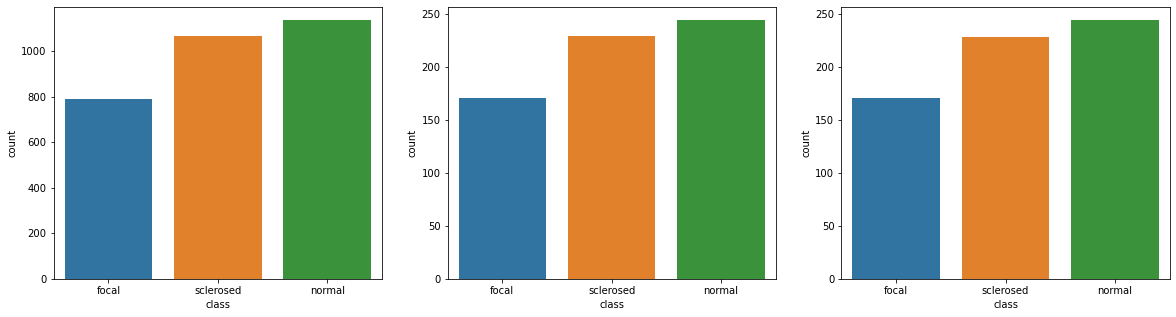

In [2]:
root_path = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/'
train_pred_test_folders = os.listdir(root_path)

train_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/train/' #one more seg_train folder within
test_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/test/'
val_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/val/'
quantity_tr = {} 
quantity_te = {}
quantity_va = {}
for folder in os.listdir(train_folders):
    quantity_tr[folder] = len(os.listdir(train_folders+folder))

for folder in os.listdir(test_folders):
    quantity_te[folder] = len(os.listdir(test_folders+folder))

for folder in os.listdir(val_folders):
    quantity_va[folder] = len(os.listdir(val_folders+folder))

quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])
quantity_val = pd.DataFrame(list(quantity_va.items()), index=range(0,len(quantity_va)), columns=['class','count'])

figure, ax = plt.subplots(1,3,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])
sns.barplot(x='class',y='count',data=quantity_val,ax=ax[2])
#sns.barplot(x='class',y='count',data=quantity_new_data,ax=ax[3])

print("Number of images in train set : ", sum(quantity_tr.values()))
print("Number of images in test set : ",sum(quantity_te.values()))
#number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in val set : ",sum(quantity_va.values()))
#print("Number of images in new dataset : ",sum(quantity_ne.values()))

plt.show()

In [3]:
IMG_SIZE = 512

In [4]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)

In [5]:
def train(BATCH_SIZE):
    train_generator = train_datagen.flow_from_directory(train_folders,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        target_size=(IMG_SIZE, IMG_SIZE))
    return train_generator

In [6]:
def validation(BATCH_SIZE):
    
    validation_generator = validation_datagen.flow_from_directory(val_folders, 
                                                                  batch_size=BATCH_SIZE, 
                                                                  class_mode='categorical', 
                                                                  target_size=(IMG_SIZE, IMG_SIZE))
    return validation_generator

In [7]:
def test(BATCH_SIZE):
    test_generator = test_datagen.flow_from_directory(test_folders,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='categorical',
                                                      target_size=(IMG_SIZE, IMG_SIZE))
    return test_generator

In [8]:
def show_few_images(number_of_examples, predict_using_model):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_folders)):
        image_ids = os.listdir(os.path.join(train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            path = os.path.join(train_folders,folder,image_ids[j])
            display = cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE))
            display = display/IMG_SIZE
            
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(predict_using_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

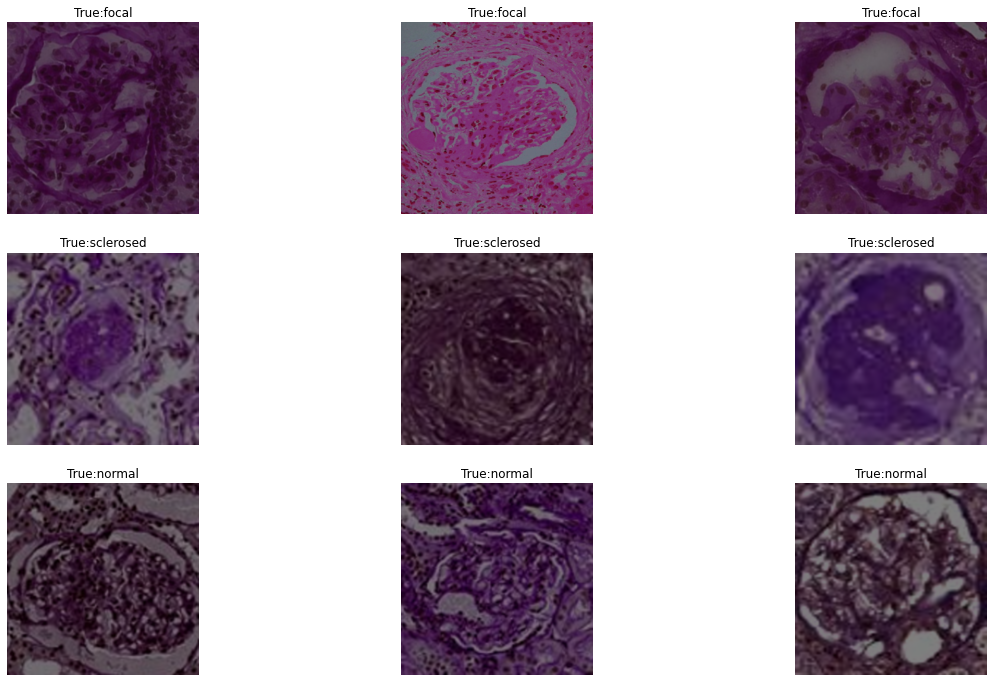

In [9]:
show_few_images(3,None)

In [10]:
with tf.device("/gpu:1"):
    model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    for layers in model.layers:
        layers.trainable=False
    last_output = model.layers[-1].output
    output = Flatten()(last_output)
    output = Dense(128, activation = 'relu')(output)
    output = Dense(3, activation = 'softmax')(output)
    model = Model(model.input, output)
    model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

In [11]:
data_train = train(1)
data_validation = validation(1)
model.fit(
    data_train,
#    steps_per_epoch=2000,
    epochs=30,
    validation_data=data_validation,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
2993/2993 [==============================] - 72s 22ms/step - loss: 17.1929 - acc: 0.5277 - val_loss: 0.8673 - val_acc: 0.5452
Epoch 2/30
2993/2993 [==============================] - 67s 22ms/step - loss: 0.8900 - acc: 0.6047 - val_loss: 0.8574 - val_acc: 0.5327
Epoch 3/30
2993/2993 [==============================] - 68s 23ms/step - loss: 0.9934 - acc: 0.5171 - val_loss: 0.8377 - val_acc: 0.5421
Epoch 4/30
2993/2993 [==============================] - 73s 24ms/step - loss: 1.0182 - acc: 0.5081 - val_loss: 0.8652 - val_acc: 0.5202
Epoch 5/30
2993/2993 [==============================] - 77s 26ms/step - loss: 0.9032 - acc: 0.5153 - val_loss: 0.8926 - val_acc: 0.5062
Epoch 6/30
2993/2993 [==============================] - 83s 28ms/step - loss: 0.9350 - acc: 0.5140 - val_loss: 0.8234 - val_acc: 0.5452
Epoch 7/30
2993/2993 [==============================] - 84s 28ms/step - loss: 0.8741 - acc: 0.5307 -

In [12]:
data_test = test(1)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
643/643 [==============================] - 18s 27ms/step - loss: 0.8446 - acc: 0.5832


[0.8445689082145691, 0.5832037329673767]

In [13]:
data_train = train(2)
data_validation = validation(2)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
1497/1497 [==============================] - 96s 59ms/step - loss: 0.6504 - acc: 0.7190 - val_loss: 0.7991 - val_acc: 0.6106
Epoch 2/10
1497/1497 [==============================] - 94s 63ms/step - loss: 0.6871 - acc: 0.7234 - val_loss: 0.7230 - val_acc: 0.6651
Epoch 3/10
1497/1497 [==============================] - 94s 63ms/step - loss: 0.6605 - acc: 0.7240 - val_loss: 0.7128 - val_acc: 0.6729
Epoch 4/10
1497/1497 [==============================] - 95s 64ms/step - loss: 0.6563 - acc: 0.7130 - val_loss: 0.7705 - val_acc: 0.6324
Epoch 5/10
1497/1497 [==============================] - 95s 63ms/step - loss: 0.6970 - acc: 0.7117 - val_loss: 0.6820 - val_acc: 0.6900
Epoch 6/10
1497/1497 [==============================] - 95s 63ms/step - loss: 0.6790 - acc: 0.7230 - val_loss: 0.7530 - val_acc: 0.6417
Epoch 7/10
1497/1497 [==============================] - 94s 63ms/step - loss: 0.6553 - acc: 0.7247 - 

In [14]:
data_test = test(2)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
322/322 [==============================] - 16s 51ms/step - loss: 0.7908 - acc: 0.6221


[0.7907849550247192, 0.6220839619636536]

In [15]:
data_train = train(4)
data_validation = validation(4)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
749/749 [==============================] - 95s 115ms/step - loss: 0.6288 - acc: 0.7317 - val_loss: 0.6785 - val_acc: 0.6963
Epoch 2/10
749/749 [==============================] - 88s 117ms/step - loss: 0.6313 - acc: 0.7327 - val_loss: 0.7717 - val_acc: 0.6340
Epoch 3/10
749/749 [==============================] - 89s 118ms/step - loss: 0.6569 - acc: 0.7230 - val_loss: 0.7618 - val_acc: 0.6386
Epoch 4/10
749/749 [==============================] - 90s 120ms/step - loss: 0.6444 - acc: 0.7207 - val_loss: 0.7346 - val_acc: 0.6558
Epoch 5/10
749/749 [==============================] - 89s 119ms/step - loss: 0.6333 - acc: 0.7367 - val_loss: 0.7046 - val_acc: 0.6791
Epoch 6/10
749/749 [==============================] - 91s 122ms/step - loss: 0.6320 - acc: 0.7300 - val_loss: 0.7459 - val_acc: 0.6511
Epoch 7/10
749/749 [==============================] - 91s 121ms/step - loss: 0.6536 - acc: 0.7277 - val_los

In [16]:
data_test = test(4)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
161/161 [==============================] - 25s 157ms/step - loss: 0.7603 - acc: 0.6796


[0.7603456974029541, 0.6796267628669739]

In [17]:
data_train = train(8)
data_validation = validation(8)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
375/375 [==============================] - 91s 216ms/step - loss: 0.6375 - acc: 0.7361 - val_loss: 0.6582 - val_acc: 0.7087
Epoch 2/10
375/375 [==============================] - 84s 222ms/step - loss: 0.6191 - acc: 0.7381 - val_loss: 0.6638 - val_acc: 0.7072
Epoch 3/10
375/375 [==============================] - 83s 221ms/step - loss: 0.6184 - acc: 0.7387 - val_loss: 0.6401 - val_acc: 0.7227
Epoch 4/10
375/375 [==============================] - 85s 225ms/step - loss: 0.6192 - acc: 0.7411 - val_loss: 0.6436 - val_acc: 0.7196
Epoch 5/10
375/375 [==============================] - 85s 224ms/step - loss: 0.6121 - acc: 0.7417 - val_loss: 0.6790 - val_acc: 0.7025
Epoch 6/10
375/375 [==============================] - 86s 227ms/step - loss: 0.6484 - acc: 0.7357 - val_loss: 0.6866 - val_acc: 0.6916
Epoch 7/10
375/375 [==============================] - 85s 224ms/step - loss: 0.6283 - acc: 0.7377 - val_los

In [18]:
data_test = test(8)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
81/81 [==============================] - 14s 175ms/step - loss: 0.6984 - acc: 0.6874


[0.6983992457389832, 0.6874027848243713]

In [19]:
data_train = train(16)
data_validation = validation(16)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
188/188 [==============================] - 70s 311ms/step - loss: 0.6115 - acc: 0.7417 - val_loss: 0.6609 - val_acc: 0.7103
Epoch 2/10
188/188 [==============================] - 63s 332ms/step - loss: 0.6143 - acc: 0.7434 - val_loss: 0.6562 - val_acc: 0.7118
Epoch 3/10
188/188 [==============================] - 62s 322ms/step - loss: 0.6093 - acc: 0.7421 - val_loss: 0.6351 - val_acc: 0.7274
Epoch 4/10
188/188 [==============================] - 63s 331ms/step - loss: 0.6184 - acc: 0.7441 - val_loss: 0.6422 - val_acc: 0.7212
Epoch 5/10
188/188 [==============================] - 64s 335ms/step - loss: 0.6553 - acc: 0.7414 - val_loss: 0.6283 - val_acc: 0.7305
Epoch 6/10
188/188 [==============================] - 62s 326ms/step - loss: 0.6098 - acc: 0.7437 - val_loss: 0.6252 - val_acc: 0.7305
Epoch 7/10
188/188 [==============================] - 65s 339ms/step - loss: 0.6034 - acc: 0.7451 - val_los

In [20]:
data_test = test(16)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
41/41 [==============================] - 10s 230ms/step - loss: 0.7105 - acc: 0.6781


[0.7104746699333191, 0.6780715584754944]

In [21]:
data_train = train(32)
data_validation = validation(32)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
94/94 [==============================] - 79s 695ms/step - loss: 0.6105 - acc: 0.7417 - val_loss: 0.6767 - val_acc: 0.6994
Epoch 2/10
94/94 [==============================] - 61s 619ms/step - loss: 0.6092 - acc: 0.7467 - val_loss: 0.6562 - val_acc: 0.7118
Epoch 3/10
94/94 [==============================] - 62s 636ms/step - loss: 0.6008 - acc: 0.7487 - val_loss: 0.6582 - val_acc: 0.7087
Epoch 4/10
94/94 [==============================] - 62s 644ms/step - loss: 0.6089 - acc: 0.7454 - val_loss: 0.6591 - val_acc: 0.7103
Epoch 5/10
94/94 [==============================] - 61s 620ms/step - loss: 0.5992 - acc: 0.7491 - val_loss: 0.6406 - val_acc: 0.7212
Epoch 6/10
94/94 [==============================] - 63s 652ms/step - loss: 0.6009 - acc: 0.7494 - val_loss: 0.6593 - val_acc: 0.7259
Epoch 7/10
94/94 [==============================] - 61s 626ms/step - loss: 0.5933 - acc: 0.7541 - val_loss: 0.6358 - va

In [22]:
data_test = test(32)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
21/21 [==============================] - 11s 537ms/step - loss: 0.6844 - acc: 0.7045


[0.6843917965888977, 0.7045100927352905]

In [23]:
data_train = train(64)
data_validation = validation(64)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
47/47 [==============================] - 95s 2s/step - loss: 0.6174 - acc: 0.7491 - val_loss: 0.6519 - val_acc: 0.7165
Epoch 2/10
47/47 [==============================] - 68s 1s/step - loss: 0.5886 - acc: 0.7548 - val_loss: 0.6408 - val_acc: 0.7305
Epoch 3/10
47/47 [==============================] - 70s 1s/step - loss: 0.6066 - acc: 0.7508 - val_loss: 0.8110 - val_acc: 0.7103
Epoch 4/10
47/47 [==============================] - 71s 1s/step - loss: 0.6311 - acc: 0.7511 - val_loss: 0.6497 - val_acc: 0.7243
Epoch 5/10
47/47 [==============================] - 71s 1s/step - loss: 0.5860 - acc: 0.7564 - val_loss: 0.6534 - val_acc: 0.7305
Epoch 6/10
47/47 [==============================] - 71s 1s/step - loss: 0.5857 - acc: 0.7561 - val_loss: 0.6725 - val_acc: 0.7227
Epoch 7/10
47/47 [==============================] - 71s 1s/step - loss: 0.5992 - acc: 0.7531 - val_loss: 0.6574 - val_acc: 0.7274
Epoch 8

In [24]:
data_test = test(64)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
11/11 [==============================] - 12s 1s/step - loss: 0.6563 - acc: 0.7294


[0.6562715768814087, 0.729393482208252]

In [ ]:
data_train = train(128)
data_validation = validation(128)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10


In [ ]:
data_test = test(128)
model.evaluate(data_test)

In [ ]:
data_train = train(256)
data_validation = validation(256)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

In [ ]:
data_test = test(256)
model.evaluate(data_test)

In [ ]:
data_train = train(512)
data_validation = validation(512)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

In [ ]:
data_test = test(512)
model.evaluate(data_test)

In [ ]:
data_train = train(1024)
data_validation = validation(1024)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

In [ ]:
data_test = test(1024)
model.evaluate(data_test)

In [ ]:
data_train = train(2048)
data_validation = validation(2048)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

In [ ]:
data_test = test(2048)
model.evaluate(data_test)